# ONNX ResNet Model

This example will show inference over an exported [ONNX](https://github.com/onnx/onnx) ResNet model using Seldon Core. We will use the Seldon S2I wrapper for Intel's NGraph. The example follows this [NGraph tutorial](https://ai.intel.com/adaptable-deep-learning-solutions-with-ngraph-compiler-and-onnx/).

 Prerequisites:
   * ```pip install seldon-core```
   * To test locally [ngraph installed](https://github.com/NervanaSystems/ngraph-onnx)
   * protoc > 3.4.0
   
To run all of the notebook successfully you will need to start it with
```
jupyter notebook --NotebookApp.iopub_data_rate_limit=100000000
```

Download ResNet model fron ONNX Zoo.

In [1]:
!wget https://s3.amazonaws.com/download.onnx/models/opset_8/resnet50.tar.gz
!tar -xzvf resnet50.tar.gz
!rm resnet50.tar.gz

--2019-01-13 14:46:56--  https://s3.amazonaws.com/download.onnx/models/opset_8/resnet50.tar.gz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.228.19
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.228.19|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 101706397 (97M) [binary/octet-stream]
Saving to: ‘resnet50.tar.gz’

resnet50.tar.gz     100%[===================>]  96.99M  26.3MB/s    in 4.4s    

2019-01-13 14:47:01 (22.3 MB/s) - ‘resnet50.tar.gz’ saved [101706397/101706397]

resnet50/
resnet50/test_data_0.npz
resnet50/test_data_2.npz
resnet50/test_data_1.npz
resnet50/test_data_set_0/
resnet50/test_data_set_0/input_0.pb
resnet50/test_data_set_0/output_0.pb
resnet50/test_data_set_1/
resnet50/test_data_set_1/input_0.pb
resnet50/test_data_set_1/output_0.pb
resnet50/test_data_set_2/
resnet50/test_data_set_2/input_0.pb
resnet50/test_data_set_2/output_0.pb
resnet50/test_data_set_3/
resnet50/test_data_set_3/input_0.pb
resnet50/test_data_set_3/outpu

In [2]:
%matplotlib inline
from keras.applications.imagenet_utils import decode_predictions
from keras.applications.resnet50 import preprocess_input
from keras.preprocessing import image
import ngraph as ng
import numpy as np
import matplotlib.pyplot as plt

Using TensorFlow backend.


## Test Model
Load ONNX model into ngraph.

In [3]:
from ngraph_onnx.onnx_importer.importer import import_onnx_file

# Import the ONNX file
models = import_onnx_file('resnet50/model.onnx')

# Create an nGraph runtime environment
runtime = ng.runtime(backend_name='CPU')

# Select the first model and compile it to a callable function
model = models[0]
resnet = runtime.computation(model['output'], *model['inputs'])


ONNX `ai.onnx` opset version 8 is not supported. Falling back to latest supported version: 7
More than one different shape in input nodes [<Constant: 'Constant_289' ([])>, <BatchNormInference: 'gpu_0/res2_0_branch2c_bn_1' ([1, 256, 56, 56])>].
More than one different shape in input nodes [<Constant: 'Constant_308' ([])>, <BatchNormInference: 'gpu_0/res2_1_branch2c_bn_1' ([1, 256, 56, 56])>].
More than one different shape in input nodes [<Constant: 'Constant_327' ([])>, <BatchNormInference: 'gpu_0/res2_2_branch2c_bn_1' ([1, 256, 56, 56])>].
More than one different shape in input nodes [<Constant: 'Constant_349' ([])>, <BatchNormInference: 'gpu_0/res3_0_branch2c_bn_1' ([1, 512, 28, 28])>].
More than one different shape in input nodes [<Constant: 'Constant_368' ([])>, <BatchNormInference: 'gpu_0/res3_1_branch2c_bn_1' ([1, 512, 28, 28])>].
More than one different shape in input nodes [<Constant: 'Constant_387' ([])>, <BatchNormInference: 'gpu_0/res3_2_branch2c_bn_1' ([1, 512, 28, 28])>].
M

Test on an image of a Zebra.

[[('n02391049', 'zebra', 0.99543387),
  ('n02423022', 'gazelle', 0.0006074826),
  ('n01518878', 'ostrich', 0.0005718305),
  ('n02422106', 'hartebeest', 0.00048323255),
  ('n02422699', 'impala', 0.0003381068)]]

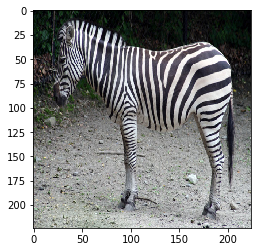

In [4]:
img = image.load_img('zebra.jpg', target_size=(224, 224))
img = image.img_to_array(img)
plt.imshow(img / 255.)
x = np.expand_dims(img.copy(), axis=0)
x = preprocess_input(x,mode='torch')
x = x.transpose(0,3,1,2)
preds = resnet(x)
decode_predictions(preds[0], top=5)

## Package Model Using S2I

In [10]:
!s2i build . seldonio/seldon-core-s2i-python3-ngraph-onnx:0.3 onnx-resnet:0.1

---> Installing application source...
---> Installing dependencies ...
Running setup.py bdist_wheel for pyyaml: started
Running setup.py bdist_wheel for pyyaml: finished with status 'done'
Stored in directory: /root/.cache/pip/wheels/ad/da/0c/74eb680767247273e2cf2723482cb9c924fe70af57c334513f
Successfully built pyyaml
Build completed successfully


In [11]:
!docker run --name "onnx_resnet_predictor" -d --rm -p 5000:5000 onnx-resnet:0.1

44ddfe45a467bed9c4b3b5d43ba09c2467c07ee1838f8ed9556b534b47706ed8


In [12]:
!seldon-core-tester contract.json 0.0.0.0 5000 -p

----------------------------------------
SENDING NEW REQUEST:


{'meta': {}, 'data': {'names': ['x'], 'ndarray': [[[[0.223, 0.113, 0.786, 0.457, 0.466, 0.309, 0.007, 0.597, 0.711, 0.7, 0.826, 0.522, 0.786, 0.116, 0.929, 0.594, 0.126, 0.119, 0.597, 0.609, 0.713, 0.627, 0.808, 0.856, 0.818, 0.428, 0.102, 0.777, 0.687, 0.658, 0.373, 0.033, 0.616, 0.42, 0.088, 0.992, 0.961, 0.592, 0.942, 0.722, 0.215, 0.058, 0.007, 0.64, 0.92, 0.955, 0.146, 0.32, 0.603, 0.691, 0.966, 0.588, 0.558, 0.601, 0.28, 0.544, 0.668, 0.297, 0.86, 0.07, 0.893, 0.969, 0.609, 0.396, 0.444, 0.776, 0.424, 0.736, 0.482, 0.489, 0.309, 0.51, 0.592, 0.131, 0.866, 0.363, 0.417, 0.72, 0.654, 0.893, 0.219, 0.185, 0.488, 0.546, 0.618, 0.972, 0.5, 0.039, 0.103, 0.762, 0.586, 0.392, 0.049, 0.53, 0.065, 0.857, 0.452, 0.581, 0.111, 0.346, 0.698, 0.389, 0.094, 0.964, 0.906, 0.673, 0.988, 0.852, 0.584, 0.394, 0.876, 0.408, 0.595, 0.034, 0.795, 0.215, 0.883, 0.421, 0.52, 0.633, 0.125, 0.694, 0.691, 0.776, 0.38, 0.497, 0.926, 0.863, 0.322, 0.266, 0.152, 0.134, 0.03, 0.946, 0.24, 0.791, 0.827, 0.192,

RECEIVED RESPONSE:
{'data': {'names': ['t:0'], 'ndarray': [[[0.00019216556393075734, 0.00067940290318802, 7.625343278050423e-05, 4.246974640409462e-05, 0.000148160062963143, 0.00018442758300807327, 2.3917684302432463e-05, 0.00023019230866339058, 5.7817243941826746e-05, 0.0006543737254105508, 0.0006225879769772291, 0.00013832787226419896, 0.00013615615898743272, 0.00021802818810101599, 3.939774978789501e-05, 0.00019794079707935452, 0.0005636754794977605, 0.0002709004911594093, 0.0002310617419425398, 9.096909343497828e-05, 0.00020753673743456602, 0.0013887733221054077, 0.0012492806417867541, 0.0002610996598377824, 0.0002483228745404631, 0.00033652051934041083, 0.0005762699875049293, 0.00014225454651750624, 0.000577955215703696, 0.0001586733415024355, 4.274226739653386e-05, 0.00016515955212526023, 7.361160533037037e-05, 3.9829803426982835e-05, 0.00019162478565704077, 5.20235626026988e-05, 0.0002866445865947753, 3.0640996556030586e-05, 0.0011817669728770852, 0.00010508211562409997, 7.74810

In [13]:
!docker rm onnx_resnet_predictor --force

onnx_resnet_predictor


# Test using Minikube

**Due to a [minikube/s2i issue](https://github.com/SeldonIO/seldon-core/issues/253) you will need [s2i >= 1.1.13](https://github.com/openshift/source-to-image/releases/tag/v1.1.13)**

In [14]:
!minikube start --memory 4096

Starting local Kubernetes v1.12.4 cluster...
Starting VM...
Getting VM IP address...
Moving files into cluster...
Setting up certs...
Connecting to cluster...
Setting up kubeconfig...
Stopping extra container runtimes...
Starting cluster components...
Verifying kubelet health ...
Verifying apiserver health ...Kubectl is now configured to use the cluster.
Loading cached images from config file.


Everything looks great. Please enjoy minikube!


In [15]:
!kubectl create clusterrolebinding kube-system-cluster-admin --clusterrole=cluster-admin --serviceaccount=kube-system:default

clusterrolebinding.rbac.authorization.k8s.io/kube-system-cluster-admin created


In [16]:
!helm init

$HELM_HOME has been configured at /home/clive/.helm.

Tiller (the Helm server-side component) has been installed into your Kubernetes Cluster.

Please note: by default, Tiller is deployed with an insecure 'allow unauthenticated users' policy.
To prevent this, run `helm init` with the --tiller-tls-verify flag.
For more information on securing your installation see: https://docs.helm.sh/using_helm/#securing-your-helm-installation
Happy Helming!


In [17]:
!kubectl rollout status deploy/tiller-deploy -n kube-system

Waiting for deployment "tiller-deploy" rollout to finish: 0 of 1 updated replicas are available...
deployment "tiller-deploy" successfully rolled out


In [18]:
!helm install ../../../helm-charts/seldon-core-crd --name seldon-core-crd  --set usage_metrics.enabled=true
!helm install ../../../helm-charts/seldon-core --name seldon-core

NAME:   seldon-core-crd
LAST DEPLOYED: Sun Jan 13 14:59:02 2019
NAMESPACE: default
STATUS: DEPLOYED

RESOURCES:
==> v1/ConfigMap
NAME                     DATA  AGE
seldon-spartakus-config  3     4s

==> v1beta1/CustomResourceDefinition
NAME                                         AGE
seldondeployments.machinelearning.seldon.io  0s

==> v1beta1/Deployment
NAME                        DESIRED  CURRENT  UP-TO-DATE  AVAILABLE  AGE
seldon-spartakus-volunteer  1        0        0           0          0s

==> v1/ServiceAccount
NAME                        SECRETS  AGE
seldon-spartakus-volunteer  1        0s

==> v1beta1/ClusterRole
NAME                        AGE
seldon-spartakus-volunteer  0s

==> v1beta1/ClusterRoleBinding
NAME                        AGE
seldon-spartakus-volunteer  0s


NOTES:
NOTES: TODO


NAME:   seldon-core
LAST DEPLOYED: Sun Jan 13 14:59:07 2019
NAMESPACE: default
STATUS: DEPLOYED

RESOURCES:
==> v1beta1/Deployment
NAME                                DESIRED  CURRENT  UP-

In [19]:
!kubectl rollout status deploy/seldon-core-seldon-cluster-manager
!kubectl rollout status deploy/seldon-core-seldon-apiserver

Waiting for deployment "seldon-core-seldon-cluster-manager" rollout to finish: 0 of 1 updated replicas are available...
deployment "seldon-core-seldon-cluster-manager" successfully rolled out
deployment "seldon-core-seldon-apiserver" successfully rolled out


In [21]:
!eval $(minikube docker-env) && s2i build . seldonio/seldon-core-s2i-python3-ngraph-onnx:0.3 onnx-resnet:0.1

---> Installing application source...
---> Installing dependencies ...
Running setup.py bdist_wheel for pyyaml: started
Running setup.py bdist_wheel for pyyaml: finished with status 'done'
Stored in directory: /root/.cache/pip/wheels/ad/da/0c/74eb680767247273e2cf2723482cb9c924fe70af57c334513f
Successfully built pyyaml
Build completed successfully


In [22]:
!kubectl create -f onnx_resnet_deployment.json

seldondeployment.machinelearning.seldon.io/seldon-deployment-example created


Wait until deployment is running

In [23]:
!kubectl get seldondeployments seldon-deployment-example -o jsonpath='{.status}'

map[predictorStatus:[map[name:onnx-resnet-deployment-onnx-resnet-predictor-21cdd95 replicas:1 replicasAvailable:1]] state:Available]

In [1]:
!seldon-core-api-tester contract.json \
    `minikube ip` `kubectl get svc -l app=seldon-apiserver-container-app -o jsonpath='{.items[0].spec.ports[0].nodePort}'` \
    --oauth-key oauth-key --oauth-secret oauth-secret -p

----------------------------------------
SENDING NEW REQUEST:


{'meta': {}, 'data': {'names': ['x'], 'ndarray': [[[[0.05734373004873161, 0.6831604756942217, 0.512260847290398, 0.00022860893286325012, 0.05331872282896566, 0.8723752141653635, 0.23170783322277477, 0.2535216036604234, 0.9366158227731375, 0.3154051894769261, 0.8494830826819761, 0.9248420073902174, 0.3827490480889034, 0.5885308648855294, 0.3233456639107962, 0.571454776928911, 0.6938653580906448, 0.5829390638616361, 0.314982956530354, 0.7261010912470438, 0.5914890392308633, 0.2538364130783052, 0.4670655411328517, 0.12981305457207204, 0.07923457408317913, 0.9633998367330292, 0.21867091655512783, 0.9106160612104517, 0.6878296055751848, 0.447168930864389, 0.1689098046286911, 0.49168822641253374, 0.7855175075233892, 0.11818741607852823, 0.7359180521375418, 0.6120933214400812, 0.5658907988245898, 0.055461402443209074, 0.12502102954461414, 0.14664814623835987, 0.2913596557226552, 0.24597831956675187, 0.9624175443325454, 0.6187263281559136, 0.4880747003398279, 0.7949505344437344, 0.833511094899

312, 0.863312594403592, 0.03102767869262879, 0.07402812289327143, 0.5887384287110272, 0.2128252659414599, 0.3648175570584681, 0.9307299452149145, 0.2484660215739467, 0.3357930142540796, 0.3876479817646086, 0.4414111939883132, 0.6928330648813774, 0.6961818068154658, 0.3656253633035349, 0.2308798713152327, 0.6269364591000978, 0.8558189737552933, 0.453198006633567, 0.8095434975666347, 0.07535167363786988, 0.8933416034043847, 0.3783900619486943, 0.3664745253775564, 0.8839863059256592, 0.9172699544996588, 0.11539610227646557, 0.8391085519265762, 0.05355111755179842, 0.18703817483465335, 0.13187859836344318, 0.7539880240526803, 0.5928749229697254, 0.6262661241482362, 0.6826995191564007, 0.003597531104321483, 0.8846421305655511, 0.014805620319303325, 0.04427611935312381, 0.44086307539383185, 0.14831019036451332, 0.6960700749188786, 0.8780025322382348, 0.875218766802917, 0.3868085357597766, 0.8312993847534185, 0.1244511948810072, 0.025913275829038795, 0.7133011787771087, 0.5878085241551342, 0.

9720157, 0.373383291669815, 0.4706584747232415, 0.7958107655998627, 0.7465872587745358, 0.29716764415074404, 0.8249830752287658, 0.6489100097953845, 0.48179004780017487, 0.980472219612339, 0.5241428202471845, 0.4486393371144305, 0.6043378860833336, 0.6596974333549966, 0.5701048997202316, 0.10402607713312206, 0.8421039429394356, 0.9692614504049711, 0.49170491152114115, 0.4545760999600481, 0.6957931515345115, 0.8421604866873343, 0.9796743976180821, 0.9799595198755251, 0.272709816880911, 0.5979701962033902, 0.47740895986867926, 0.7151611211435015, 0.3522540145065025, 0.47236505529771866, 0.691483539493741, 0.8350830534497993, 0.351856030715772, 0.8615630482595094, 0.3530669876972139, 0.1635571647911389, 0.8999039295769821, 0.4790496293892844, 0.3911986726287582, 0.34084291557594837, 0.3810952272975433, 0.5973494953428441, 0.6281054326491122, 0.8417219671269071, 0.32656396371656693, 0.19274832165469868, 0.10259253630542686, 0.8450316740262315, 0.8971989669329077, 0.7905127136929587, 0.2391

653, 0.10893639929342336, 0.2167154414056598, 0.6627588211855145, 0.4732932890473842, 0.80312184901523], [0.3490804252676415, 0.799866705421523, 0.378743634634897, 0.42640543832470357, 0.46561249682655126, 0.7580026827722454, 0.3381619419042283, 0.6454312135155599, 0.685572203689449, 0.5509617524574675, 0.34446803692978956, 0.609759894254985, 0.4174981364954753, 0.1851515574193987, 0.5414852347632483, 0.7632471927033362, 0.11146489552465222, 0.9474297290728371, 0.14052680291322106, 0.016923079613525682, 0.6052917351602898, 0.624904415609133, 0.011424871131803793, 0.4354372867430355, 0.14703822961048796, 0.24036823411178765, 0.5395408592077049, 0.38025202343172815, 0.9906495060792838, 0.2627271089435661, 0.7318871367904227, 0.7709518277949537, 0.709378138582723, 0.06544797990933549, 0.1502927966819121, 0.6624742386751284, 0.4257335571218389, 0.8629609377086652, 0.47662047054238876, 0.4391721790352733, 0.9399821405079557, 0.1912079666776677, 0.8381978224648355, 0.46663382128572695, 0.639

7, 0.9387881351916768, 0.8311229135595665, 0.8680088931637013, 0.5226558538508851, 0.4154487944539178, 0.9649609946435722, 0.8133087574361243, 0.9075683110528514, 0.09502937616185558, 0.7438154948418751, 0.12920821427645357, 0.23093385359494767, 0.3747515313037282, 0.1062933843693733, 0.8580308678931494, 0.9707356568937675, 0.03287328518674637, 0.021292934294924515, 0.14733878977943993, 0.18379385907541557, 0.7093651314716057, 0.8380899555365565, 0.6012767338795867, 0.720750125307585, 0.6825421710989661, 0.6482715421299255, 0.7541453193903137, 0.4706497426190617, 0.3960744365488851, 0.6666216961608619, 0.4132495410530582, 0.9658180003986948, 0.33813026214665043, 0.04176200399231744, 0.07601761139995011, 0.04583204770957472, 0.7591444008627785, 0.8740658878917116, 0.33489080215967115, 0.2239994927703537, 0.411428325416736, 0.615946467593191, 0.8787681226860927, 0.7011320028094521, 0.06165736535655597, 0.11456529025641915, 0.37962930135834405, 0.5016573641067361, 0.5083098701987948, 0.66

0109, 0.12303174822576146, 0.9131290033502182, 0.24880466768245912, 0.8699417541578732, 0.24284603574269814, 0.8472931604538844, 0.8223985827821542, 0.4369984209667477, 0.7576303490976628, 0.05237624290009946, 0.9535009805507613, 0.6642205366289375, 0.8338134590655466, 0.8705750984724894, 0.400738987117377, 0.3242571582503444, 0.41170736384297946, 0.13561982684600948, 0.9768732831940675, 0.8502194413172399, 0.9173660754070109, 0.7959262391289326, 0.847860887065681, 0.359857575392885, 0.28848832589908235, 0.08824965153508102, 0.5690727145748089, 0.3136671574994998, 0.1644365557571179, 0.7315038463647399, 0.6061949521744026, 0.755182045471824, 0.20870585528434704, 0.6621479186744555, 0.8533245345416973, 0.3651810624419428, 0.614327663708654, 0.9578815599934184, 0.5464322140354946, 0.1612236521281577, 0.31334123616281984, 0.5590779221316788, 0.7698870450795642, 0.6654172058274289, 0.7098893680294405, 0.508860046590288, 0.5742800995996235, 0.25550488454898324, 0.8794667778639473, 0.3587399

31783078, 0.429348559964018, 0.678296847614867, 0.59365809801648, 0.02570816717754476, 0.3392142051829349, 0.5499603312107595, 0.7391916834472676, 0.9840818749384245, 0.48686134789369406, 0.5608092910686346, 0.035113570194857946, 0.1600581008495583, 0.135053397258046, 0.7417363350289423, 0.4217494285981337, 0.07432729041723474, 0.4702559241227806, 0.6701448426676674, 0.6764163439016032, 0.8259524620253492, 0.4312759753478389, 0.6768839259295423, 0.04437888431989534, 0.3610083973069993, 0.1205989660848601, 0.8619630567785488], [0.3069506049083661, 0.421027261842464, 0.21245498333470259, 0.10948432277859288, 0.10196021775918074, 0.08630360698808481, 0.3620156411842126, 0.27029279034829523, 0.4638273028571146, 0.09968030002228356, 0.6919876847011002, 0.49574374699640833, 0.14320250471135232, 0.8562132668070702, 0.019134199506022243, 0.20074297645221495, 0.32708028073242756, 0.6145825901502141, 0.2226109471217339, 0.8567109275518346, 0.9406401423576193, 0.8546912572898338, 0.70545289297760

 0.2664625974503986, 0.7928396823882429, 0.8578113797214953, 0.5519929512244779, 0.693238989217374, 0.7300573548010736, 0.7664459316642411, 0.8825351621400078, 0.2473480210441814, 0.14219991913531682, 0.05792917252837326, 0.7267654566319053, 0.14095307780898902, 0.30437858613035185, 0.8752226540228694, 0.42304640184351305, 0.6544227643102207, 0.18095474241414833, 0.8206131122114096, 0.5062186562105279, 0.11610302649068927, 0.3318113682619168, 0.676981880236995, 0.3881824474681006, 0.07782100381218204, 0.06405713686675574, 0.647681774197776, 0.8642986724555856, 0.4911106494178423, 0.3823327809922782, 0.3523065325111142, 0.7795386354212287, 0.7568131307304953, 0.9268320233089801, 0.7204071982301253, 0.3333116731636748, 0.9297744995573115, 0.5463623947333217, 0.8817396469248017, 0.44209396759967, 0.28430030221392544, 0.3145809083614026, 0.2090100377854872, 0.5912651173346343, 0.3497783136627648, 0.020716901181417113, 0.7323856693136226, 0.07770169757543222, 0.4013840036538465, 0.802075947

27, 0.4349354625727625, 0.05657038519550528, 0.49067607493813625, 0.19118611427673182, 0.5942571239017296, 0.7914244828526363, 0.756747935749585, 0.17667492429980713, 0.6044724470108801, 0.37010521368828286, 0.2449436757218567, 0.30036791357954984, 0.19812924863787562, 0.5409003330535688, 0.7096150473344878, 0.22188663581758838, 0.4029259736388021, 0.1534351934067012], [0.44644992753670254, 0.47878289343975244, 0.12117760299004265, 0.2256019887593047, 0.4043770453768467, 0.3397565268000968, 0.16491158181988474, 0.7875888576918547, 0.3132073688732644, 0.7587020318965081, 0.41242918739799017, 0.31014309843749865, 0.2474377495424519, 0.6005121616755671, 0.3510915531921541, 0.973287534331774, 0.5127557329579728, 0.6099744572379097, 0.7342320984174937, 0.7559302612480476, 0.5233728944655395, 0.31779692026603745, 0.8436928989575249, 0.9160339213992761, 0.6897376209580965, 0.36669990317636525, 0.6726901245294515, 0.6794177340795259, 0.6681515720661743, 0.9781338303408611, 0.000713473693362720

2, 0.3927806603992593, 0.3547987462256825, 0.0676351817800096, 0.0759015303275612, 0.6599514020408238, 0.5255449115448723, 0.8947791442400123, 0.8442741638462894, 0.11087350454907063, 0.3462316449115367, 0.09844757203240351, 0.21795469954854785, 0.6980070301103001, 0.195315464419621, 0.7491828032981525, 0.2628426512515961, 0.18002549748135244, 0.28990657139670284, 0.5042004723721973, 0.35656417748663716, 0.40017347315820384, 0.7175641439618328, 0.017634812523538823, 0.8257982463869527, 0.45604985688442756, 0.6153134105439809, 0.7398491283891613, 0.5898693483805578, 0.6166168236607994, 0.11177453026190076, 0.5752085897778271, 0.32334990419925913, 0.5722131965063585, 0.7686671808619537, 0.7180386423594286, 0.3792395832168549, 0.9087701393668548, 0.5149982837367002, 0.9437439051318801, 0.4976914902567453, 0.4355181779280406, 0.09754996566683705, 0.18925618472131678, 0.1301984832472608, 0.8352011678291803, 0.4172632643913906, 0.20650243982097094, 0.3476065861345816, 0.07717602425451575, 0.

0196641596503, 0.8268193941674782, 0.6078726944484847, 0.9538220281072396, 0.9906713050140895, 0.13030368751585664, 0.07161377289288018, 0.4764456729219041, 0.9297275009082775, 0.1785374207143262, 0.5386073143351532, 0.2543822438537052, 0.9627716684452804, 0.8402753775840188, 0.36377652544401773, 0.17699336656927012, 0.2951523064628798, 0.30592532013429496, 0.7843028931510445, 0.10164182059817317, 0.35675253500795356, 0.3922875844234942, 0.8021632096047955, 0.44007475892103776, 0.36543651817422695, 0.3672575524676288, 0.6731684330806936, 0.7224498894461086, 0.6033849453251875, 0.5860932315230754, 0.46324886505531093, 0.5183434253257176, 0.5534395999891274, 0.16947006865298142, 0.19745333241945584, 0.40135130118072415, 0.7625826673626903, 0.8163122699785306, 0.5605739802038859, 0.8039738452995608, 0.16414826076904532, 0.1854184447925129, 0.016125219979689964, 0.8843018936158948], [0.19990920882133456, 0.692829056733524, 0.3077390077916121, 0.15899665153678355, 0.6940233472206548, 0.7310

2017527, 0.9927610904193496, 0.8424708332469071, 0.45867025556771013, 0.7024733671492501, 0.48223168203112476, 0.14699229119795265, 0.38129203593067695, 0.2892344861013292, 0.7338713876733531, 0.8779262384663732, 0.3919925592949738, 0.8683654683509461, 0.8710355340469792, 0.6004002336114338, 0.7257709899995086, 0.17203945026292788, 0.9877007952090208, 0.2945669816311527, 0.4784807477991655, 0.8299031352114886, 0.9879768593835877, 0.8434744427707955, 0.8604204870055937, 0.45307300116048854, 0.4185680713431902, 0.22397354242670864, 0.7587405633133112, 0.2443200693138463, 0.7645423798284909, 0.8607467911516741, 0.634992779330583, 0.8046270856592077, 0.3077413308753886, 0.9743119293889936, 0.3644334929231503, 0.4676001670748813, 0.4845887241394464, 0.1408583665880896, 0.8307391536970026, 0.16017872468305983, 0.22848445236466108, 0.3682339896579617, 0.14516468367566937, 0.9886236176857801, 0.08554584123561926, 0.8474983676947485, 0.6803935539118219, 0.3808157333910208, 0.739830730704646, 0.

47558744, 0.6567154623579192, 0.4171548569799748, 0.9881052932508395, 0.21023727727660957, 0.7622711065082175, 0.5140263716552103, 0.6185107494157094, 0.5300726532193264, 0.912733581632315, 0.8219413516302446, 0.23499109049918532, 0.6207936404646538, 0.9043457389224225, 0.9290113822430986, 0.20956682747433653, 0.7147241764296983, 0.7276379885701149, 0.6599780223318515, 0.5045215404729626, 0.09452911260656183, 0.9915013324229724, 0.47966870931261685, 0.47407931277394566, 0.3158713782575737, 0.21494494216480953, 0.24215764873150103, 0.7715944097048257, 0.06054291234171649, 0.8170835857687709, 0.5613474514785665, 0.6735538430507203, 0.4145690712027086, 0.40629219754364365, 0.5589535104912334, 0.8598276368828535, 0.7156203000063932, 0.7091128339110848, 0.4603734043100033, 0.5178907714500911, 0.7282389703260459, 0.8734000313025548, 0.686794278966012, 0.12904673707213077, 0.8469233726290916, 0.9152199050619446, 0.48197307220276764, 0.6058051039733802, 0.4742082815459273, 0.45923539815071135,

2, 0.7988687461425459, 0.7790123377190026, 0.21149315150144132, 0.9575825825913498, 0.6407121251586267, 0.3704475481007682, 0.2805091791743707, 0.544957672490487, 0.9965057117996832, 0.027545329224490822, 0.29017267297617144, 0.44377275099183455, 0.7596737051330444, 0.5938324640231489, 0.5235060431149167, 0.6318074867393386, 0.7382739962722141, 0.7969819226342633, 0.3631717242865433, 0.043651356332149116, 0.4519970819427116, 0.28733453391388175, 0.06334553223298278, 0.9667071883257579, 0.9549622380986768, 0.07733326122188222, 0.8281476009968836, 0.850104649728347, 0.5460388259693784, 0.6041995921581081, 0.4628823211903701, 0.3844306011662594, 0.6403683360444316, 0.40656299921140016, 0.6563724304409734, 0.4224132836773069, 0.004152178440742338, 0.3642257675647378, 0.5280160994388373, 0.2915812296803454, 0.7866910249088558, 0.3176517107674921, 0.3114826441204258, 0.8400743754053847, 0.8432756997411571, 0.5023334164592806, 0.038300243407061396, 0.9303544278831175, 0.14894770913375743, 0.9

58175391301928, 0.3079115127304102, 0.7518637447581585, 0.3053185152590786, 0.5778436913775943, 0.7789892514260479, 0.1926729096981561, 0.5001233638332111, 0.7329438481182414, 0.26476178271165074, 0.8055878429535833, 0.190818980397628, 0.8592822014611539, 0.25605657114632685, 0.34847333722563767, 0.7731470373255291, 0.2046828221467072, 0.15764179242867382, 0.8072870920930391, 0.8529607733842257, 0.7656523434155641, 0.12405629367494575, 0.382465084799982, 0.021640228774580272, 0.29006736741733363, 0.6111645678546467], [0.31818957653689073, 0.37277828828698867, 0.19813618473199213, 0.954861720371534, 0.5572712785429152, 0.777753204001931, 0.8787377492539811, 0.9731643397900365, 0.02489592438793997, 0.28695824193366826, 0.08951039978140618, 0.9883262585185408, 0.7283132557861169, 0.445561172474943, 0.4699820088335781, 0.12520979880102023, 0.1639258300523604, 0.07109037060955214, 0.8551036633855572, 0.55466883949997, 0.26836026420298753, 0.7342666699393602, 0.9352735926441982, 0.7824517238

0.5716608405100319, 0.08408800886216505, 0.23515486893925064, 0.37291489587810933, 0.8470066611196391, 0.33149375089542243, 0.6900864582791213, 0.8587414177819879, 0.1520802499561521, 0.7998656553304164, 0.565663059663963, 0.9075552571476999, 0.17112633133584065, 0.6074574870919092, 0.2927447776764114, 0.7104158688706953, 0.6198999724247817, 0.32009984299776495, 0.48519208041510153, 0.06855285114764698, 0.4671395473874347, 0.8531971856399256, 0.8058891860137017, 0.4682398616366229, 0.3099793837918129, 0.2545187253408836, 0.28100613342543646, 0.012735873712756529, 0.27766274969439286, 0.35826902867005306, 0.087562611914901, 0.12054768094487822, 0.900784603594679, 0.37461546407954593, 0.6441891911768828, 0.4190213992091244, 0.4283523469717344, 0.9386951807505359, 0.5866165281513419, 0.6975252739734237, 0.7414968216375663, 0.07935289598837725, 0.8611513690106034, 0.911665757350157, 0.8947635528179313, 0.15378375626483176, 0.7724852711388894, 0.8749984297419867, 0.3561725120817464, 0.78717

22, 0.9590236874316463, 0.17736409156382638, 0.8399721066741185, 0.48059650187357017, 0.031178463693171454, 0.09816278529958711, 0.2803519924385338, 0.07600047097292406, 0.3767717403568307, 0.9219232977920834, 0.08118339438510724, 0.15696148072593885, 0.08198831370491855, 0.6841239803056974, 0.42052715480080083, 0.6131372167590838, 0.5171833066462826, 0.5871160929745551, 0.29927877257111046, 0.7051324284135151, 0.05670955051330817, 0.45164473866810106, 0.9021817580814534, 0.218375269488567, 0.7738286671743424, 0.7030558213399801, 0.771933234233489, 0.6669694551781533, 0.9021582673678211, 0.8282413074377414, 0.1985047859360093, 0.6032135738109903, 0.6029987617586771, 0.6653369015576869, 0.5843846247752065, 0.9318650105727309, 0.9462884938736065, 0.43670597606594563, 0.8568549417604775, 0.08012700185011012, 0.12859413783924734, 0.560628305109717, 0.02032780867915629, 0.2856898541457571, 0.45088224792807985, 0.7448177339338119, 0.030576723595701738, 0.2055281745928389, 0.43405452169672376

44100154402, 0.021399557938811542, 0.42358758283995057, 0.38312240251567176, 0.04459535269616399, 0.7129478751191465, 0.4840860570668081, 0.9869545807946069, 0.7480567121321241, 0.728558632291578, 0.19288266085269257, 0.34702919071162197, 0.8634579279198679, 0.640961010991241, 0.3121290840754263, 0.5620446562080095, 0.4029673601561381, 0.8458250544362251, 0.18476901326448236, 0.9901644030013116, 0.5369601220071312, 0.4297699837972303, 0.9478332046009357, 0.6669522505903585, 0.029705524325117527, 0.5859266816319485, 0.9530746845612944, 0.9279904243503279, 0.4361495900146085, 0.24703088222615455, 0.6578517337661492, 0.7464731996648789, 0.32672437539388466, 0.1752667724492598, 0.09549806455301135, 0.3380854302236428, 0.27155696651977745, 0.18378617871846958, 0.022340673289385604, 0.01084031000458685, 0.8739266705640351, 0.6535828326879043, 0.5329523484124722, 0.7237458983862199, 0.8180343772669824, 0.9412130015120853, 0.7756490949366778, 0.6622577040154952, 0.9309411875607743, 0.647394052

24572, 0.581441006495641, 0.9017613866970373, 0.5258686181786776, 0.5996345716538295, 0.0247133239614602, 0.033684044832482885, 0.3026199659828799, 0.15942569667889606, 0.6973002523214006, 0.6602354850386413, 0.13353720549840842, 0.9546763533073004, 0.7559660299793028, 0.9352638802763799, 0.2551804550684371, 0.8733610444944396, 0.3842629785954538, 0.44800026491579514, 0.4478410909684565, 0.7364804375847154, 0.815584388440824, 0.024759951094726507, 0.6183115674912008, 0.30306953304919104, 0.10899747888753653, 0.8337196860199817, 0.9149976382417473, 0.7672685665333338, 0.2845506204251892, 0.21537741767198515, 0.34028770756562843, 0.32698391860250153, 0.6178298499188999, 0.2632014711148909, 0.16395666750355042, 0.2340463823293064, 0.8411594664706163, 0.18971422215665368, 0.8423632979315542, 0.8364975551741376, 0.9292928664624294, 0.2733911111196399, 0.467145582111142, 0.5535758194047181, 0.878701490523001, 0.8393018484817162, 0.2983511769413111, 0.0871304490156849, 0.8076135490436368, 0.3

241243762885, 0.2339152930881172, 0.8727814899601454, 0.7143626441585466, 0.5595100664445788, 0.3100440426465405, 0.5951452211925031, 0.8230210329749039, 0.7632717035171391, 0.958107638634017, 0.4717602288068432, 0.8498257396791659, 0.27119607744714, 0.4546913391347468, 0.9959491871101005, 0.11235032893695762, 0.283290311953161, 0.14340370023868054, 0.7330748120913737, 0.18130708469502765, 0.3942523108747569, 0.5945927946403042, 0.7762792140497081, 0.7872516015779542, 0.6847579616779399, 0.03616631394334335, 0.9252155077398113, 0.5906320021780358, 0.9569649907433783, 0.14114216007724567, 0.3666314050550127, 0.26152629931351346, 0.45627663236144067, 0.6571405866139777, 0.41381386785235075, 0.650332799594638, 0.15793996859787585, 0.5092608614109829, 0.409115078770387, 0.683931917897923, 0.6044032308213102, 0.026453233702106393, 0.7791886253757883, 0.7992898063534277, 0.0018772756047052974, 0.12053785361667413, 0.33920733885376697, 0.9060478353116261, 0.37268740954673907, 0.86869203824097

.263020636443532, 0.06934763242437658, 0.4635469112958631, 0.0069329135215056015, 0.3268809640485335, 0.26826597912742645, 0.16926621260346397, 0.7809174273938615, 0.37672614216175737, 0.6831394831984774, 0.9596133795119898, 0.4204511726385428, 0.8758555305815028, 0.4830229346360816, 0.15818343951331626, 0.3779150371668081, 0.8252569496838157, 0.06071145180162951, 0.04691739315958421, 0.06539993402863908, 0.30249194752022457, 0.701898431631321, 0.5247300033886287, 0.888979057950971, 0.5087993664986333, 0.48273409040583626, 0.6527651490323584, 0.8401284549868006, 0.21526731823866752, 0.8995225079402768, 0.16700589453295855], [0.8088279533945498, 0.771802280496626, 0.32266713297030225, 0.030606110705684197, 0.90972248988315, 0.47653171660611116, 0.2966652041869361, 0.47195462229954177, 0.045653521924797436, 0.9848881171164544, 0.6022200786189967, 0.9023795058308839, 0.635353551343917, 0.1964702414793955, 0.2492626395890808, 0.15786926619956376, 0.04737513261035031, 0.11081051506342765, 0

547362546, 0.119828182240721, 0.9786434206522739, 0.3643919631829128, 0.901506492156836, 0.15753359886052642, 0.6561667873765324, 0.25358592958175397, 0.7055658635997939, 0.78496618345393, 0.3984769571208491, 0.37994332950136456, 0.18176950957396576, 0.1818180572530812, 0.5248023551708482, 0.219926120223353, 0.07067166696791294, 0.7971951373831749, 0.1591238683282603, 0.24596165420947214, 0.05674937525684709, 0.09230784357348254], [0.003362981104050866, 0.6357649573930058, 0.15318465091622235, 0.25784839614549404, 0.6406298371825377, 0.5325136536752679, 0.7995416016652336, 0.5342333826928485, 0.9370436018940235, 0.07120554202895046, 0.752015688328773, 0.4127239820425409, 0.36383562302104167, 0.026349815707272017, 0.011826668943804242, 0.4028316979703561, 0.35682341212239166, 0.4259634191382534, 0.57927162210558, 0.9546833175157992, 0.6645690354556071, 0.7760595289640762, 0.13348158341196326, 0.7285594311755283, 0.24115512505835124, 0.22616808409353373, 0.7863939293592285, 0.05057969105

9996, 0.32575166880650386, 0.5955674891653726, 0.775032115887123, 0.16602796283685817, 0.7333564070747028, 0.35233315336594595, 0.1677217973508326, 0.5182437654630141, 0.24558160179208355, 0.4171979046746491, 0.40999113712864543, 0.8598939484940182, 0.8701155695735927, 0.017634409161639164, 0.8309694282703308, 0.4563448744742733, 0.9280444966045202, 0.6594376173436355, 0.07040808304541457, 0.09193367308414713, 0.33818529016931187, 0.6807030054598214, 0.15714085717572124, 0.8263274121982689, 0.45085560188611895, 0.969137503975552, 0.15499586899283735, 0.7233993657613148, 0.5865462367230727, 0.598061360249293, 0.6932233124464314, 0.9563724652295662, 0.15196399259982896, 0.44966356467104396, 0.5610112131099279, 0.2612850269318989, 0.8500896600196529, 0.6948415852049582, 0.8219146842888514, 0.6563539100043375, 0.6017466856887369, 0.8998138342154931, 0.706682054172123, 0.2220391544348327, 0.8143997510181674, 0.26981750984901065, 0.768538535939908, 0.46004106379797527, 0.7710867027431114, 0.

46778, 0.11731187182089264, 0.7336547921888112, 0.283099483031243, 0.0472006521180518, 0.7518927635403716, 0.9116211715780219, 0.1968790774999133, 0.8365377199578169, 0.24117991198259703, 0.2807441357086099, 0.3891674547113855, 0.742654522892009, 0.6059034519095454, 0.013084845612570173, 0.06893161714602258, 0.3245248020158481, 0.3886375633101917, 0.9703293141715408, 0.8396561157579239, 0.22649244138727476, 0.5491720902225992, 0.8576581291471865, 0.6992655302315662, 0.37082509680033526, 0.8487221091794325, 0.0816430563588415, 0.3574064549003776, 0.553771519319653, 0.059414729180012005, 0.4487117443861366, 0.13327499220219297, 0.1810686741550347, 0.8417790333584585, 0.27040799805157567, 0.7942907366950763, 0.1702741115354045, 0.870563334528542, 0.6196840517628894, 0.3716514127845495, 0.31888546824785047, 0.8370085283801348, 0.4876465676247206], [0.6791581744198256, 0.024772250242143135, 0.44903365008653096, 0.03900076697501642, 0.771413101020594, 0.8978173907099721, 0.43320094175891055,

In [ ]:
!minikube delete
